# Milestone 2

### Imports

In [1]:
%cd ..
# imports 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scripts_m2 import *
# Loading the training data
import json 


/Users/omarahmed/Omar/SEM 10/NLP/Projects/NLP_PROJECT_111/QA Task milestone


### 1. Loading the data

In [2]:
with open('data/m2_train.json', 'r') as f:
    squad_data = json.load(f)

print(squad_data['data'][0]['paragraphs'][0].keys())

print(json.dumps(squad_data['data'][0], indent=2))

dict_keys(['qas', 'context'])
{
  "title": "Beyonc\u00e9",
  "paragraphs": [
    {
      "qas": [
        {
          "question": "When did Beyonce start becoming popular?",
          "id": "56be85543aeaaa14008c9063",
          "answers": [
            {
              "text": "in the late 1990s",
              "answer_start": 269
            }
          ],
          "is_impossible": false
        },
        {
          "question": "What areas did Beyonce compete in when she was growing up?",
          "id": "56be85543aeaaa14008c9065",
          "answers": [
            {
              "text": "singing and dancing",
              "answer_start": 207
            }
          ],
          "is_impossible": false
        },
        {
          "question": "When did Beyonce leave Destiny's Child and become a solo singer?",
          "id": "56be85543aeaaa14008c9066",
          "answers": [
            {
              "text": "2003",
              "answer_start": 526
            }
          ],


### 3. Data Exploration

#### Counting Answerable Questions vs Unanswerable Questions

In [3]:
# Counting the number of answerable and unanswerable questions
num_answerable = 0
num_unanswerable = 0

for article in squad_data["data"]:
    for paragraph in article["paragraphs"]:
        for qa in paragraph["qas"]:
            if qa["is_impossible"]:
                num_unanswerable += 1
            else:
                num_answerable += 1

print("Number of answerable questions: ", num_answerable)
print("Number of unanswerable questions: ", num_unanswerable)
print("Number of QA pairs: ", num_answerable + num_unanswerable)

Number of answerable questions:  86821
Number of unanswerable questions:  43498
Number of QA pairs:  130319


Answerable vs. Unanswerable Questions in SQuAD 2.0

- **Answerable Questions:** The correct answer exists within the given passage, and the model must extract the exact span.
- **Unanswerable Questions:** The passage does not contain the answer, and the model should predict "No Answer."

SQuAD 2.0 introduces unanswerable questions to make the task more challenging, requiring models to distinguish between when an answer is present and when it is not.

In this notebook, we will use answerable questions only in the subset we will be training our neural networks on

#### Explore Answer length distribution

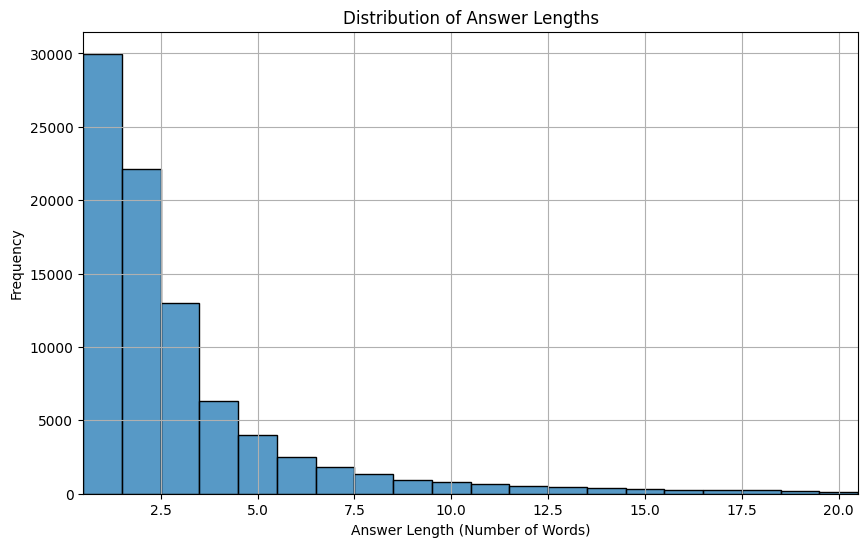

In [4]:
# explore answer length distribution

answer_lengths = []
for article in squad_data["data"]:
    for paragraph in article["paragraphs"]:
        for qa in paragraph["qas"]:
            if not qa["is_impossible"]:
                for answer in qa["answers"]:
                    answer_lengths.append(len(answer["text"].split()))

plt.figure(figsize=(10, 6))
sns.histplot(answer_lengths, bins=range(1, 22), discrete=True)
plt.title("Distribution of Answer Lengths")
plt.xlabel("Answer Length (Number of Words)")
plt.ylabel("Frequency")
plt.xlim(0.5, 20.5)  # to center bars on integers
plt.grid()
plt.show()

- The vast majority of answers are very short, with 1-word and 2-word answers dominating the distribution.

### 2. Preprocessing the dataset

In [5]:
# Clean text function
import re

def clean_text(text: str, is_question: bool=False):
    """
    Cleans text by removing extra spaces, newline characters, and special symbols.
    """
    if is_question:
        text = text.replace("\n", " ").replace("\t", " ")  # Remove newlines & tabs
        text = re.sub(r"\s+", " ", text)  # Remove extra spaces
        text = text.strip()  # Trim leading/trailing spaces
    text = text.lower()  # Convert to lowercase
    return text

# Testing the clean_text function on a sample text
sample_text = "   This is a \n\n\t sample    text.    "
print("Original text:", sample_text)
print("Cleaned text:", clean_text(sample_text))

Original text:    This is a 

	 sample    text.    
Cleaned text:    this is a 

	 sample    text.    


In [6]:
# Load and process the SQuAD dataset
def load_and_process_squad(filepath, max_samples=20000):
    """
    Loads, cleans, and extracts answerable questions from the SQuAD dataset.

    Args:
        filepath (str): Path to the SQuAD JSON file.
        max_samples (int): Maximum number of answerable questions to load.

    Returns:
        List[dict]: A list of cleaned question-answer pairs.
    """
    with open(filepath, "r") as f:
        squad_data = json.load(f)

    data = []
    for article in squad_data["data"]:
        for paragraph in article["paragraphs"]:
            context = clean_text(paragraph["context"]) 
            for qa in paragraph["qas"]:
                if qa["is_impossible"]:  
                    continue
                
                question = clean_text(qa["question"], is_question=True) 
                answer_text = clean_text(qa["answers"][0]["text"])  
                answer_start = qa["answers"][0]["answer_start"]
                
                data.append({
                    "context": context, 
                    "question": question, 
                    "answer": answer_text, 
                    "answer_start": answer_start, 
                    "answer_end": answer_start + len(answer_text)})


    data.sort(key=lambda x: (len(x["answer"]), len(x["context"])))
    # Limit the number of samples if specified
    if max_samples > 0:
        data = data[:max_samples]
    return data

# Load and process the SQuAD dataset
train_dataset = load_and_process_squad("data/m2_train.json", max_samples=-1)
dev_samples = load_and_process_squad("data/m2_dev.json", max_samples=2000)

print("Number of QA pairs in train data:", len(train_dataset))
print("Training sample:", train_dataset[0].keys())
print("\n")
print("Number of QA pairs in test data:", len(dev_samples))
print("Dev sample:", dev_samples[0].keys())


Number of QA pairs in train data: 86821
Training sample: dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])


Number of QA pairs in test data: 2000
Dev sample: dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])


### 3. Tokenization

In [7]:
unique_words = set()

for sample in train_dataset:
    context = sample["context"]
    question = sample["question"]
    answer = sample["answer"]

    unique_words.update(set(re.findall(r"\w+", context)))
    unique_words.update(set(re.findall(r"\w+", question)))
    unique_words.update(set(re.findall(r"\w+", answer)))

                
# Print the number of unique words
print("Number of unique words in the training set:", len(unique_words))

Number of unique words in the training set: 82597


In [8]:
combined_text = []
for sample in train_dataset:
    combined_text.append(sample["context"])
    combined_text.append(sample["question"])
    combined_text.append(sample["answer"])

# Join all text samples into one corpus (you can also use '\n'.join for a more distinct separation)
combined_text = "\n".join(combined_text)


In [9]:
# Training the tokenizer
from scripts_m2 import *

# Creating / Loading the tokenizer
tokenizer = BPETokenizer()

# Training the tokenizer if not already trained
tokenizer.train(combined_text=combined_text.split("/n"), vocab_size=10000)


Loading tokenizer from ./tokenizers/tokenizer.json...
Tokenizer already exists at ./tokenizers/tokenizer.json. Skipping training.


In [10]:
# Encoding a Question
example_question = train_dataset[4]["question"]
tokenized_output, attention_mask = tokenizer.encode(example_question)
print("Tokenized Question:", tokenized_output)
print("Length of Tokenized Question:", len(tokenized_output))
print("Attention Mask:", attention_mask)

# Decoding the tokenized output
decoded_output = tokenizer.decode(tokenized_output)
print("Decoded Question:", decoded_output)

Tokenized Question: [3, 2475, 2222, 1974, 2582, 1359, 1266, 7147, 2100, 3360, 1980, 8995, 4388, 1359, 1266, 4065, 5553, 7147, 1974, 2125, 2339, 4871, 1390, 4]
Length of Tokenized Question: 24
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Decoded Question: how many of west ' s albums were included on rolling stone ' s 500 greatest albums of all time list ?


In [11]:
# Changing the max tokenizer length
tokenizer.set_max_length(25)

In [12]:
# Encoding an answer
example_answer = train_dataset[4]["answer"]
tokenized_answer, attention_mask = tokenizer.encode(example_answer)
print("Tokenized Answer:", tokenized_answer)
print("Length of Tokenized Answer:", len(tokenized_answer))
print("Attention Mask:", attention_mask)

# Decoding the tokenized answer
decoded_answer = tokenizer.decode(tokenized_answer)
print("Decoded Answer:", decoded_answer)

Tokenized Answer: [3, 1312, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Length of Tokenized Answer: 25
Attention Mask: [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded Answer: 3


### 4. Dataset & Data Loaders

In [13]:
# Getting the dataset
train_dataset = load_and_process_squad("data/m2_train.json", max_samples=20000)
dev_dataset = load_and_process_squad("data/m2_dev.json", max_samples=2000)
print("Number of training samples:", len(train_dataset))
print("Number of dev samples:", len(dev_dataset))

Number of training samples: 20000
Number of dev samples: 2000


In [14]:
# View the number of unique contexts
unique_contexts = set()
for sample in train_dataset:
    unique_contexts.add(sample["context"])
print("Number of unique contexts in the training set:", len(unique_contexts))

Number of unique contexts in the training set: 11203


In [15]:
# Create the tokenizer
tokenizer = BPETokenizer()
# Train the tokenizer
tokenizer.train(combined_text=combined_text.split("\n"), vocab_size=10000)

Loading tokenizer from ./tokenizers/tokenizer.json...
Tokenizer already exists at ./tokenizers/tokenizer.json. Skipping training.


In [16]:
# View the training data
random_idx = np.random.randint(0, len(train_dataset))

# Print the random sample
print(train_dataset[random_idx].keys())
print("Training data sample:")
print(train_dataset[random_idx]["context"])
print(train_dataset[random_idx]["question"])
print(train_dataset[random_idx]["answer"])
print("Answer start:", train_dataset[random_idx]["answer_start"])
print("Answer end:", train_dataset[random_idx]["answer_end"])
print("Length of the training examples:", len(train_dataset))

dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])
Training data sample:
one of the primary functions of a brain is to extract biologically relevant information from sensory inputs. the human brain is provided with information about light, sound, the chemical composition of the atmosphere, temperature, head orientation, limb position, the chemical composition of the bloodstream, and more. in other animals additional senses may be present, such as the infrared heat-sense of snakes, the magnetic field sense of some birds, or the electric field sense of some types of fish. moreover, other animals may develop existing sensory systems in new ways, such as the adaptation by bats of the auditory sense into a form of sonar. one way or another, all of these sensory modalities are initially detected by specialized sensors that project signals into the brain.
the group of animals that can detect magnetic fields is what?
birds
Answer start: 446
Answer end: 451
Length of the

In [17]:
q = tokenizer.encode(train_dataset[4]["question"])[0]
tokenizer.decode(q)

'how many libraries are in bern ?'

In [18]:
# Viewing the length of the longest question, context, and answer
max_context_length = max(len(tokenizer.encode(sample["context"])[0]) for sample in train_dataset)
max_question_length = max(len(tokenizer.encode(sample["question"])[0]) for sample in train_dataset)
max_answer_length = max(len(tokenizer.encode(sample["answer"])[0]) for sample in train_dataset)

print("Max context length:", max_context_length)
print("Max question length:", max_question_length)
print("Max answer length:", max_answer_length)

Max context length: 976
Max question length: 50
Max answer length: 9


Summary Statistics for Context Lengths:
Number of questions: 20000
Number of outliers: 707
Minimum: 29
Q1 (25%): 130.0
Median: 164.0
Q3 (75%): 213.0
Maximum: 976
Interquartile Range (IQR): 83.0
95th Percentile: 318.0
97th Percentile: 345.0
99th Percentile: 417.0099999999984


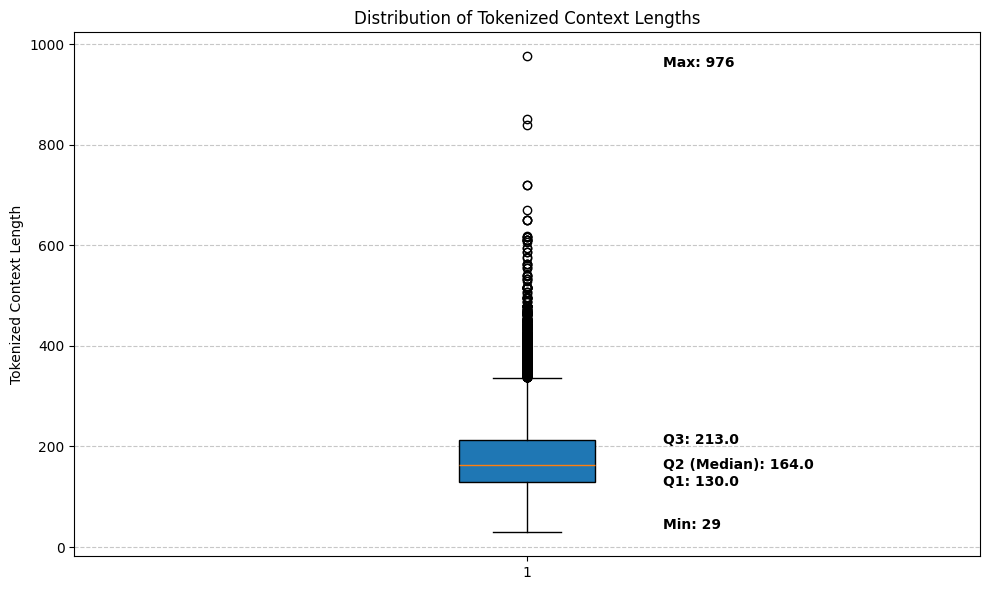

In [19]:
# Visualizing the distribution of tokenized question lengths
context_lengths = [len(tokenizer.encode(sample["context"])[0]) for sample in train_dataset]
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(context_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Context Lengths")
plt.ylabel("Tokenized Context Length")

# Calculate and display quartiles
quartiles = np.percentile(context_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(context_lengths)
max_val = np.max(context_lengths)

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}', 
         verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}', 
         verticalalignment='top', fontweight='bold')

print(f"Summary Statistics for Context Lengths:")
print("Number of questions:", len(context_lengths))
print("Number of outliers:", len([x for x in context_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in context_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Summary Statistics for Question Lengths:
Number of questions: 20000
Number of outliers: 295
Minimum: 3
Q1 (25%): 12.0
Median: 15.0
Q3 (75%): 18.0
Maximum: 50
Interquartile Range (IQR): 6.0
95th Percentile: 23.0
97th Percentile: 25.0
99th Percentile: 29.0


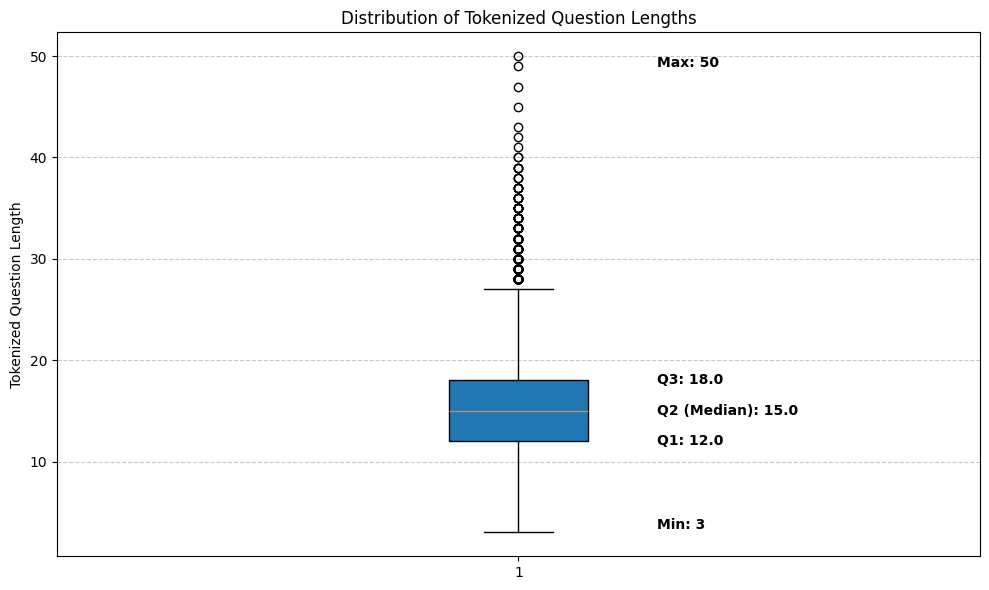

In [20]:
# Visualizing the distribution of tokenized question lengths
question_lengths = [len(tokenizer.encode(sample["question"])[0]) for sample in train_dataset]
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(question_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Question Lengths")
plt.ylabel("Tokenized Question Length")

# Calculate and display quartiles
quartiles = np.percentile(question_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(question_lengths)
max_val = np.max(question_lengths)

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}', 
         verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}', 
         verticalalignment='top', fontweight='bold')

print(f"Summary Statistics for Question Lengths:")
print("Number of questions:", len(question_lengths))
print("Number of outliers:", len([x for x in question_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in question_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Summary Statistics for Answer Lengths:
Number of answers:  20000
Number of outliers:  1478
Minimum: 3
Q1 (25%): 3.0
Median: 4.0
Q3 (75%): 4.0
Maximum: 9
Interquartile Range (IQR): 1.0
95th Percentile: 6.0
97th Percentile: 6.0
99th Percentile: 7.0


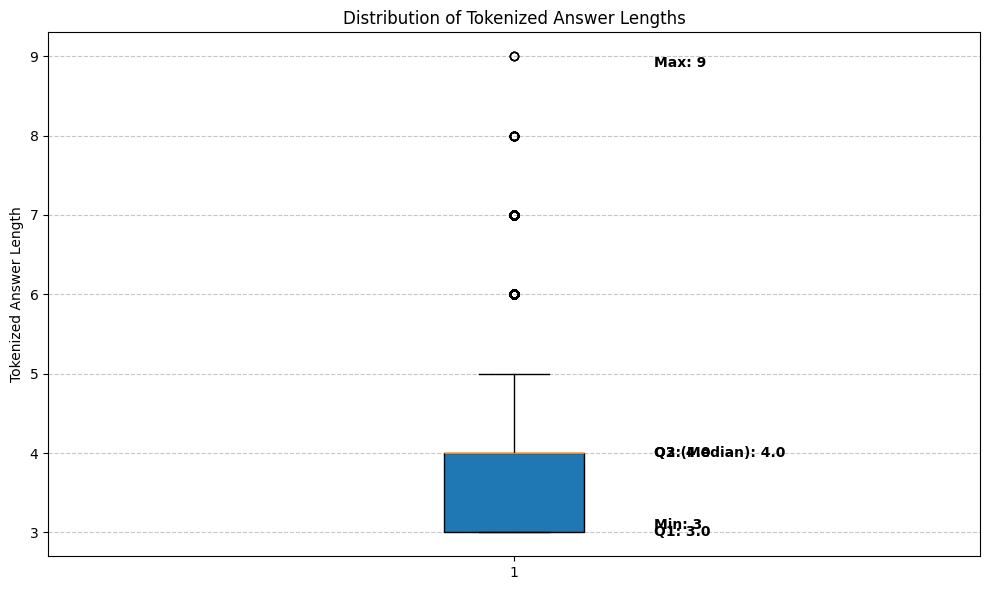

In [21]:
# Visualizing the distribution of tokenized answer lengths
answer_lengths = [len(tokenizer.encode(sample["answer"])[0]) for sample in train_dataset]

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(answer_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Answer Lengths")
plt.ylabel("Tokenized Answer Length")
# Calculate and display quartiles
quartiles = np.percentile(answer_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(answer_lengths)
max_val = np.max(answer_lengths)

print(f"Summary Statistics for Answer Lengths:")
print("Number of answers: ", len(answer_lengths))
print("Number of outliers: ", len([x for x in answer_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in answer_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}',
            verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}',
            verticalalignment='top', fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Summary Statistics for context + question Lengths:
Number of context + question:  20000
Number of outliers:  711
Minimum: 39
Q1 (25%): 144.0
Median: 179.0
Q3 (75%): 227.0
Maximum: 988
Interquartile Range (IQR): 83.0
95th Percentile: 333.0
97th Percentile: 361.0
99th Percentile: 430.0


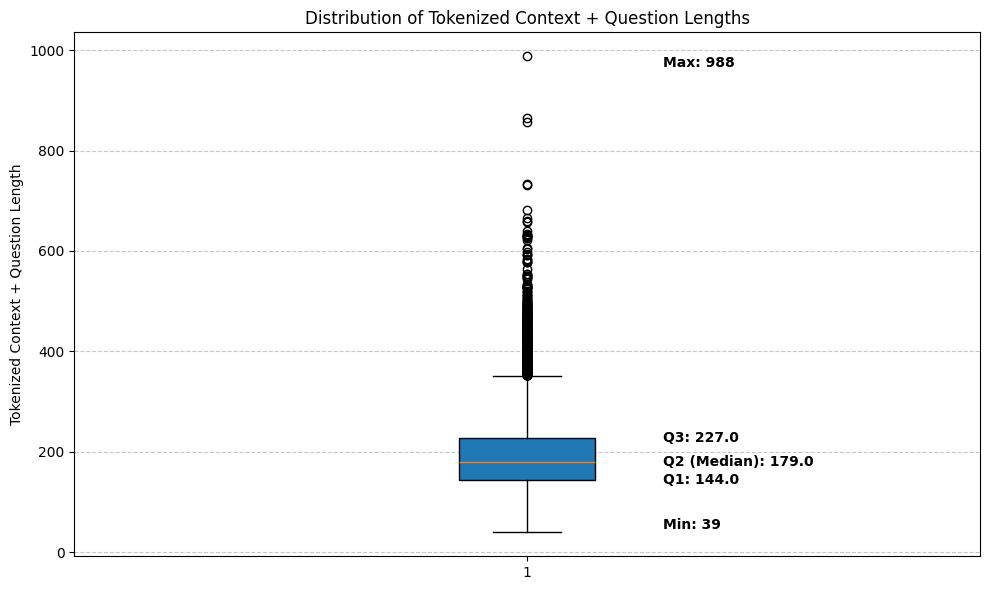

In [22]:
# Visualizing the distribution of tokenized answer lengths
context_question_lengths = [len(tokenizer.encode_two_texts(sample["context"], sample["question"])[0]) for sample in train_dataset]

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(context_question_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Context + Question Lengths")
plt.ylabel("Tokenized Context + Question Length")
# Calculate and display quartiles
quartiles = np.percentile(context_question_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(context_question_lengths)
max_val = np.max(context_question_lengths)

print(f"Summary Statistics for context + question Lengths:")
print("Number of context + question: ", len(context_question_lengths))
print("Number of outliers: ", len([x for x in context_question_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in context_question_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}',
            verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}',
            verticalalignment='top', fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

So for the transformer based models we can use the max length of the question and answer as follows:
1. `Answers Max Length`: 6 tokens
2. `Question Max Length`: 23 tokens
3. `Context Max Length`: 318 tokens
4. `Context + Question Length`: 318+23+1 (+1 for [SEP]) We could have used 175 as it is the 95th percentile but we will use 191 instead


This would give us a good tradeoff between the length of the sequence without using a lot of padding.

In [23]:
# Creating dataset
tokenizer = BPETokenizer()
train_data = load_and_process_squad("data/m2_train.json", max_samples=20000)
dev_data = load_and_process_squad("data/m2_dev.json", max_samples=2000)

context_max_length = 318
question_max_length = 23
answer_max_length = 6
train_dataset = QADataset(train_data, tokenizer, context_max_length=context_max_length, question_max_length=question_max_length, answer_max_length=answer_max_length, include_context=True)
dev_dataset = QADataset(dev_data, tokenizer, context_max_length=context_max_length, question_max_length=question_max_length, answer_max_length=answer_max_length, include_context=True)
print("Number of training samples:", len(train_dataset))
print("Number of dev samples:", len(dev_dataset))

# View a sample from the dataset
random_idx = np.random.randint(0, len(train_dataset))
print("Sample from the dataset:")
print("Question encoded:", train_dataset[random_idx]["question"])
print("Question decoded: ", tokenizer.decode(train_dataset[random_idx]["question"].tolist()))
print("Answer encoded:", train_dataset[random_idx]["answer"])
print("Answer decoded: ", tokenizer.decode(train_dataset[random_idx]["answer"].tolist()))
print("Context encoded:", train_dataset[random_idx]["context"])
print("Context decoded: ", tokenizer.decode(train_dataset[random_idx]["context"].tolist()))
print("\n\n")

# View a sample from the dev dataset
random_idx = np.random.randint(0, len(dev_dataset))
print("Sample from the dev dataset:")
print("Context encoded:", dev_dataset[random_idx]["context"])
print("Context decoded: ", tokenizer.decode(dev_dataset[random_idx]["context"].tolist()))
print("Question encoded:", dev_dataset[random_idx]["question"])
print("Question decoded: ", tokenizer.decode(dev_dataset[random_idx]["question"].tolist()))
print("Answer encoded:", dev_dataset[random_idx]["answer"])
print("Answer decoded: ", tokenizer.decode(dev_dataset[random_idx]["answer"].tolist()))
print("Context Question encoded:", dev_dataset[random_idx]["context_question"])
print("Context Question decoded: ", tokenizer.decode(dev_dataset[random_idx]["context_question"].tolist()))
print("Answer Start:", dev_dataset[random_idx]["answer_start"])
print("Answer End:", dev_dataset[random_idx]["answer_end"])
print("Answer Start: End decoded:", tokenizer.decode(dev_dataset[random_idx]["context"][dev_dataset[random_idx]["answer_start"]:dev_dataset[random_idx]["answer_end"]+1].tolist()))


Loading tokenizer from ./tokenizers/tokenizer.json...
Filtered dataset size: 19922 out of original 20000
Filtered dataset size: 1989 out of original 2000
Number of training samples: 19922
Number of dev samples: 1989
Sample from the dataset:
Question encoded: tensor([   3, 2087, 2022, 2951, 2713, 2038, 5379, 4882, 2801, 2579, 2075, 1966,
        7067, 1390,    4,    1,    1,    1,    1,    1,    1,    1,    1])
Question decoded:  what was another name for hardcore techno from the netherlands ?
Answer encoded: tensor([   3,   49, 2048, 2197,    4,    1])
Answer decoded:  gabber
Context encoded: tensor([   3, 1267, 2229, 5526, 1974, 5154, 2272, 1990, 9293, 1359, 1266, 2240,
        2451, 1978, 1966, 6978, 1974, 4344, 2100, 4393, 1989, 4020, 1267, 2836,
        2344, 2038, 2283, 4137, 7875, 1321, 2683, 3610, 4257, 2855, 1989, 4092,
        1314, 4292, 5154, 1314, 3869, 2239, 2178, 2200, 5021, 1321, 2392, 4292,
        5154, 5910, 2333, 8222, 2653, 2028, 2324, 4883, 2051, 7196, 3862, 1283,


In [24]:
# Creating Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) # add this `num_workers=0` if you want to see print in __getitem__ in dataset class
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

for batch in train_dataloader:
    print(batch.keys())
    print(batch['context_question'].shape)
    print(batch['question'].shape)
    print(batch['answer'].shape)
    print(batch['attention_mask_question'].shape)
    print(batch['attention_mask_answer'].shape)
    print(batch['attention_mask_context_question'].shape)
    print(batch['answer_start'], batch['answer_end'])
    print(batch['context_question_type_mask'].shape)
    print("-" * 50)
    input_ids = batch['context_question']
    attention_mask = batch['attention_mask_context_question']
    token_type_ids = batch['context_question_type_mask']
    break

dict_keys(['question', 'attention_mask_question', 'answer', 'attention_mask_answer', 'context', 'attention_mask_context', 'context_question', 'attention_mask_context_question', 'answer_start', 'answer_end', 'context_question_type_mask'])
torch.Size([32, 342])
torch.Size([32, 23])
torch.Size([32, 6])
torch.Size([32, 23])
torch.Size([32, 6])
torch.Size([32, 342])
tensor([117,  68,  68,  92,  19,   7,  58,  10, 103,  94,  14,  64,  79,   4,
        159,  58,  87,  42,  54,  19,  44,  51,  50,  30, 123,  28,  11, 149,
         28,  19,   9,  63]) tensor([117,  69,  68,  92,  20,   8,  59,  11, 103,  95,  15,  64,  79,   5,
        161,  58,  87,  42,  54,  19,  44,  52,  50,  31, 123,  28,  11, 152,
         30,  22,   9,  63])
torch.Size([32, 342])
--------------------------------------------------


In [25]:
context_max_length + question_max_length

341

In [26]:
# Try the full data preprocessing function
train_dataloader, val_dataloader, tokenizer = prepare_dataloaders_tokenizer()

Loading tokenizer from ./tokenizers/tokenizer.json...
Filtered dataset size: 19922 out of original 20000
Filtered dataset size: 1989 out of original 2000
